In [1]:
!rm -rf pytorch_utils
!git clone https://github.com/toniqapps/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 120 (delta 69), reused 45 (delta 18), pack-reused 0
Receiving objects: 100% (120/120), 37.28 KiB | 229.00 KiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==0.4.6 is successfully installed


In [3]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
from pytorch_utils import dataset
train, test = dataset.cifar10_albumentations()

Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/test_batch


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


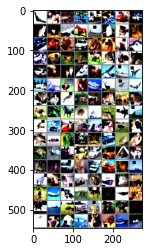

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [9]:
from torchsummary import summary
from pytorch_utils import models

net = models.CIFAR10_RESNET_S8(models.BasicBlock, [2, 2, 2, 2]).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [10]:
import torch.optim as optim
import torch.nn as nn

from pytorch_utils import lrfinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)

# The model is trained for num_iter iterations while the learning rate is
# increased from its initial value specified by the optimizer algorithm to end_lr
lr_finder = lrfinder.LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.31E-03


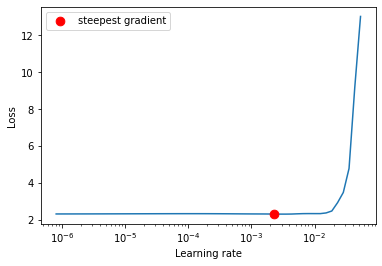

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2a5b62fbe0>,
 0.0023101297000831605)

In [11]:
lr_finder.plot(skip_end=0)

In [12]:
# restore the model and optimizer to their initial state
lr_finder.reset()

In [12]:
import torch.optim as optim
from pytorch_utils import train, test
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=2.31e-3, momentum=0.9, weight_decay=5e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min') #StepLR(optimizer, step_size=20, gamma=0.1)
model_name = 'cifar_10_plot'

train_losses = dict()
train_acc = dict()
test_losses = dict()
test_acc = dict()

train_losses[model_name] = []
train_acc[model_name] = []
test_losses[model_name] = []
test_acc[model_name] = []


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_loss, tr_acc = train.train(net, device, trainloader, optimizer, criterion, epoch, [], dict())
    te_loss, te_acc = test.test(net, device, testloader, criterion)
    scheduler.step(te_loss[0])
    train_losses[model_name].extend(tr_loss)
    train_acc[model_name].extend(tr_acc)
    test_losses[model_name].extend(te_loss)
    test_acc[model_name].extend(te_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.01436767540872097 Batch_id=390 Accuracy=99.63: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 4341/5000 (86.82%)

EPOCH: 1


Loss=0.032956015318632126 Batch_id=19 Accuracy=99.69:   5%|▌         | 20/391 [00:09<02:55,  2.12it/s]

KeyboardInterrupt: ignored

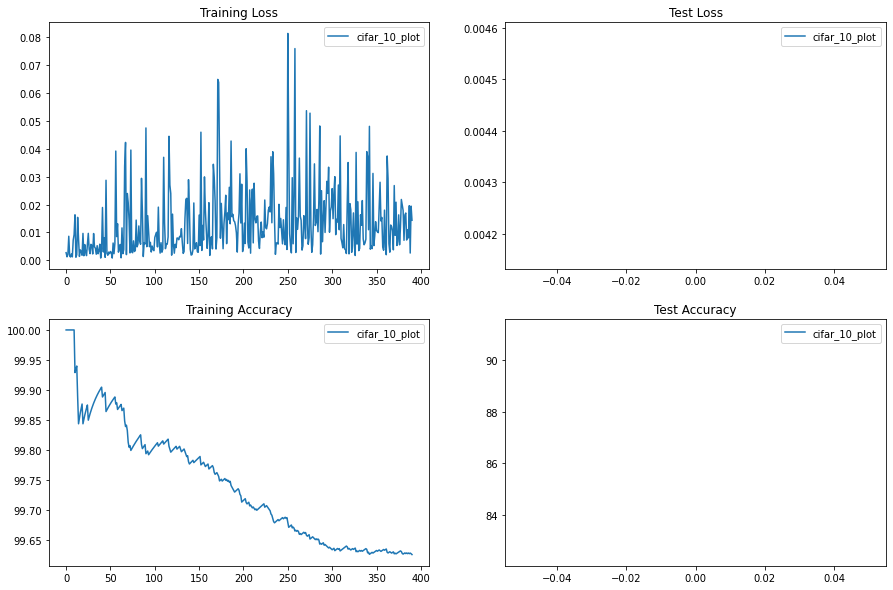

In [13]:
from pytorch_utils import utils

utils.plot_results(train_losses, train_acc, test_losses, test_acc)

In [10]:
# Save the model
#torch.save(net.state_dict(), "eva5_s10.pth")

# Load the model
#net.load_state_dict(torch.load("eva5_s10.pth"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/content/pytorch_utils/gradcam.py:111: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / np.max(cam)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)

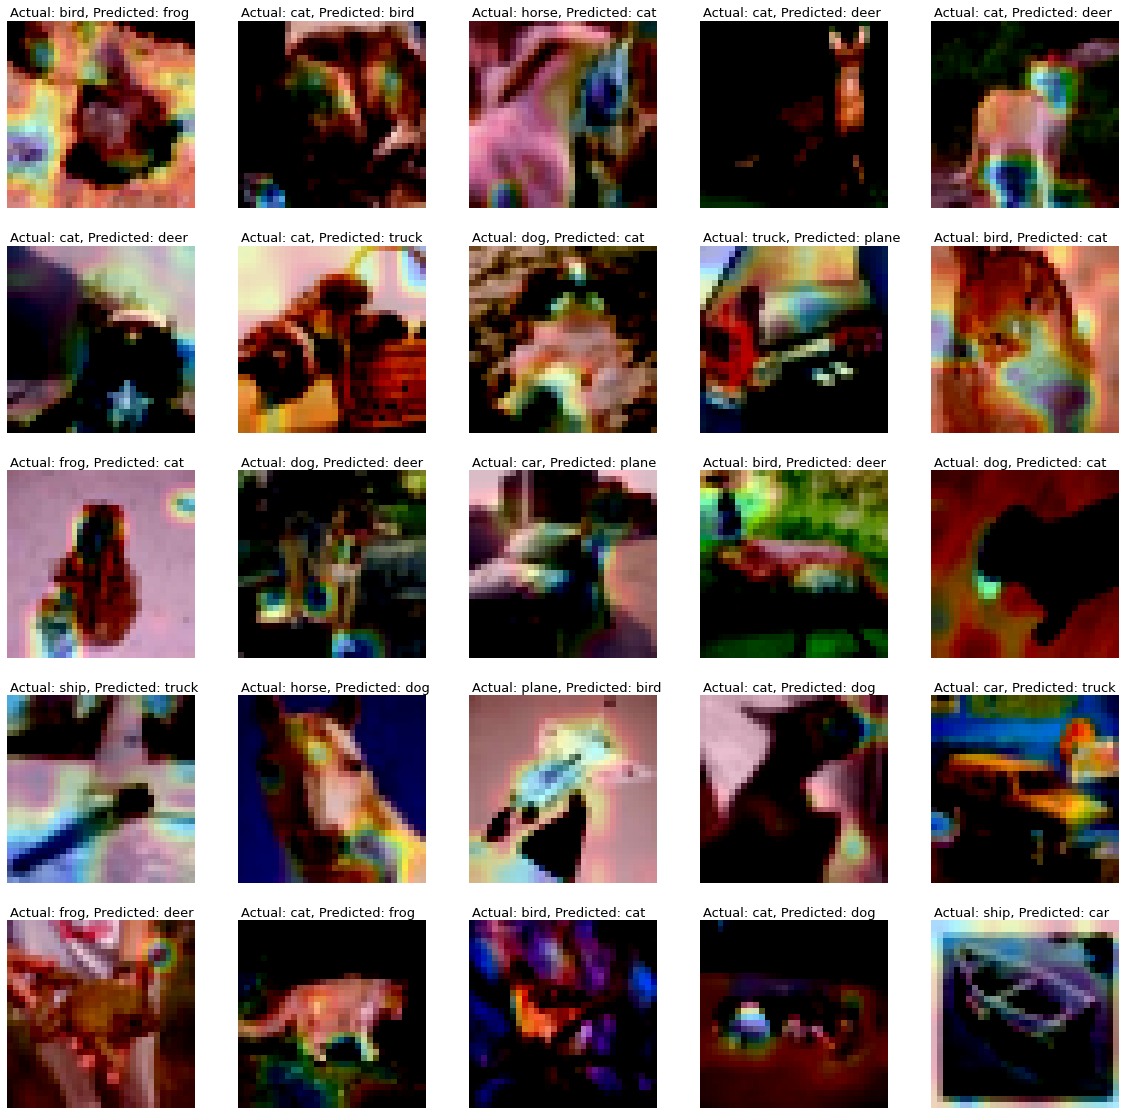

In [11]:
from pytorch_utils import gradcam

gradcam.gradcam_misclassified_images_from_model(net, testloader, classes, 25, net.layer3, ["1"])